Calculate population diversity statistics:
- nucleotide diversity
- Waterson Theta
- Tajima D

All statistics look similar to the whole-genome counterparts:
- https://github.com/malariagen/ag1000g-phase2-data-paper/blob/master/artwork/pi.jpeg
- https://github.com/malariagen/ag1000g-phase2-data-paper/blob/master/artwork/Watterson_theta.jpeg
- https://github.com/malariagen/ag1000g-phase2-data-paper/blob/master/artwork/Tajimas_D.jpeg

In [1]:
%run common.ipynb

## Allele counts per population

In [2]:
# concatenate variants from all amplicons into a single array
ampl_snps = list()
for ampl in callset:
    ampl_snps.append(callset[ampl]['genotype'])
ampl_snps = allel.GenotypeChunkedArray(np.concatenate(ampl_snps))
# # snps, samples, ploidy
ampl_snps.shape

(2112, 1142, 2)

In [3]:
# population allele counts
grp = samples.groupby(['population'])
pop_ampl_ac = ampl_snps.count_alleles_subpops(grp.indices)
pop_ampl_ac

<AlleleCountsChunkedTable shape=(2112,) dtype=[('AOcol', '<i4', (2,)), ('BFcol', '<i4', (2,)), ('BFgam', '<i4', (2,)), ('CIcol', '<i4', (2,)), ('CMgam', '<i4', (2,)), ('FRgam', '<i4', (2,)), ('GAgam', '<i4', (2,)), ('GHcol', '<i4', (2,)), ('GHgam', '<i4', (2,)), ('GM', '<i4', (2,)), ('GNcol', '<i4', (2,)), ('GNgam', '<i4', (2,)), ('GQgam', '<i4', (2,)), ('GW', '<i4', (2,)), ('KE', '<i4', (2,)), ('UGgam', '<i4', (2,))]
   nbytes=264.0K cbytes=30.8K cratio=8.6
   values=allel.chunked.storage_zarr.ZarrTable>

## Positions

In [4]:
# total length of amplicon inserts
ampl_len = sum(panel_mosquito.end_insert - panel_mosquito.start_insert)
ampl_len

9920

In [5]:
corr_pos = list()
shift = 0
for _, r in panel_mosquito.iterrows():
    # read AgamP4 coordinates
    init_p = callset[r.name]['POS'][:]
    # transform into concatenated sequence coordinates
    corr_p = init_p - r.start_insert + shift
    # shift to next amplion
    shift += r.end_insert - r.start_insert
    corr_pos.extend(corr_p)
corr_pos[-5:]

[9885, 9896, 9898, 9901, 9910]

## Nucleotide diversity

In [6]:
# estimate
pop_pi = dict()
for pop in populations:
    pop_pi[pop] = allel.sequence_diversity(corr_pos, 
                                  pop_ampl_ac[pop], 
                                  start=1, 
                                  stop=ampl_len)

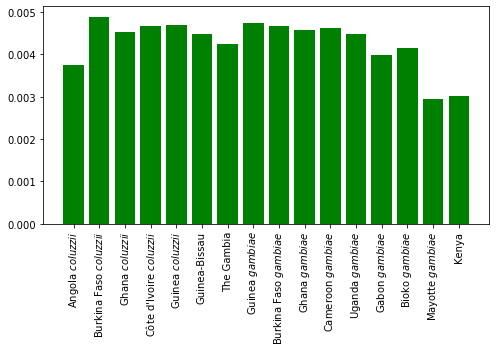

In [7]:
# plot
fig, ax = plt.subplots(figsize=(8,4))
for pop in populations:
    ax.bar(pop_labels[pop], pop_pi[pop], color='g')
plt.xticks(rotation=90);

## Watterson theta

In [8]:
# estimate
pop_wt = dict()
for pop in populations:
    pop_wt[pop] = allel.watterson_theta(corr_pos, 
                                   pop_ampl_ac[pop], 
                                   start=1, 
                                   stop=ampl_len)

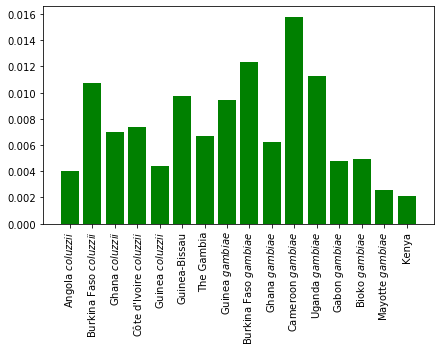

In [9]:
fig, ax = plt.subplots(figsize=(7,4))
for pop in populations:
    ax.bar(pop_labels[pop], pop_wt[pop], color='g')
plt.xticks(rotation=90);

## Tajima D

In [10]:
# estimate
pop_td = dict()
for pop in populations:
    pop_td[pop] = allel.tajima_d(pop_ampl_ac[pop], 
                            corr_pos, 
                            start=1, 
                            stop=ampl_len)

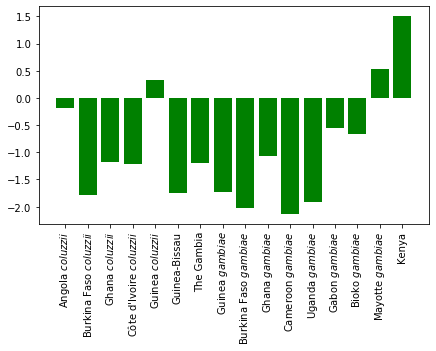

In [11]:
fig, ax = plt.subplots(figsize=(7,4))
for pop in populations:
    ax.bar(pop_labels[pop], pop_td[pop], color='g')
plt.xticks(rotation=90);

# Table

In [12]:
div = pd.DataFrame([pop_pi, pop_wt, pop_td], 
        index=['Nucleotide diversity',
               'Watterson theta',
               'Tajima D'])
# div = div.rename(columns=pop_labels)
div

,AOcol,BFcol,GHcol,CIcol,GNcol,GW,GM,GNgam,BFgam,GHgam,CMgam,UGgam,GAgam,GQgam,FRgam,KE
Nucleotide diversity,0.003758,0.004891,0.004528,0.004661,0.004698,0.004484,0.004251,0.004739,0.004660,0.004582,0.004618,0.004490,0.003994,0.004142,0.002941,0.003024
Watterson theta,0.003997,0.010740,0.006997,0.007402,0.004432,0.009769,0.006670,0.009464,0.012363,0.006236,0.015794,0.011282,0.004820,0.004924,0.002567,0.002080
Tajima D,-0.193222,-1.787253,-1.183534,-1.216388,0.327269,-1.748475,-1.198649,-1.728932,-2.015475,-1.066109,-2.131662,-1.919231,-0.560940,-0.672653,0.522424,1.502772


In [13]:
div.to_csv(DIV_FILE)